# Load Data for Cell 1 with K and Ca channels

In [1]:
import numpy as np
import pandas as pd

In [2]:
from brian2 import *

In [3]:
from __future__ import print_function
from pylab import *
from clampy.analysis.electrode_compensation import *
from clampy import *
from scipy import optimize
from clampy.setup.units import *
from clampy.analysis.cell_analysis import *
import numpy as np
from clampy.analysis.spike_analysis import lowpass

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/clampy-0.1-py3.7.egg/clampy/devices/__init__.py:11: UserWarning: Failed to import the Axoclamp 900A module
  warn('Failed to import the Axoclamp 900A module')
 [py.warnings]


In [4]:
import os

In [5]:
cwd=os.getcwd()
cwd

'/home/alteska/Desktop/brian/brian_dev/real_data/cell1'

In [6]:
path=cwd + '/'
full=True
filtering=1*ms

In [7]:
print('Analysis')
cmap = cm.bwr

# *** Loading ***
# Parameters
info = load_info(path+'current_pulses.info')
dt, ntrials, long_kernel_size = info['dt'], info['ntrials'], info['kernel_size']
pulse_start, pulse_duration = info['pulse_start'], info['pulse_duration']

Analysis


In [8]:
# Load AEC calibration
signals = np.load(path+'/AEC.npz')
V1_noise, V2_noise = signals['V1'], signals['V2']
try: # Test if it is a two_electrode experiment (inject through Ic2, read on V1) or not
    I_noise = signals['Ic']
except KeyError:
    I_noise = signals['Ic2']

In [9]:
# Kernel calculation
kernel_size = int(20 * ms / dt)
ekernel_size = int(1.5 * ms / dt)

In [10]:
# Determine injecting electrode
K1 = full_kernel(V1_noise / volt, I_noise / amp, kernel_size)
K2 = full_kernel(V2_noise / volt, I_noise / amp, kernel_size)
R1, R2 = sum(K1), sum(K2)

In [11]:
if R1>R2:
    injecting_electrode = 'V1'
    recording_electrode = 'V2'
    K = K1
else:
    injecting_electrode = 'V2'
    recording_electrode = 'V1'
    K = K2
    V1_noise, V2_noise = V2_noise, V1_noise
    R1, R2 = R2, R1
if R2>5e6: # if more than 5 MOhm, then we assume there actually is an electrode
    two_electrodes = True
else:
    two_electrodes = False

Ke = electrode_kernel_soma(K, ekernel_size) # 15 time steps
print("Electrode resistance = ",float(sum(Ke)/Mohm),"Mohm")

Electrode resistance =  11.302666611418962 Mohm


In [12]:
# Load pulse experiment
amplitudes = loadtxt(path + '/Pulses/amplitudes.txt')
V, V2, Ic, Vraw = [], [], [], []
for i in range(ntrials):
    signals = np.load(path+'/Pulses/pulses{}.npz'.format(i))
    if i==0:
        t = signals['t']
    Vraw.append(signals[injecting_electrode])
    V2.append(signals[recording_electrode])
    try:
        Ic.append(signals['Ic'])
    except KeyError:
        Ic.append(signals['Ic2'])
    V.append(AEC_compensate(Vraw[i], Ic[i], Ke))

V, V2, Ic, Vraw = array(V), array(V2), array(Ic), array(Vraw)
Imin = min(mean(Ic, axis=1))
Imax = max(mean(Ic, axis=1))

def get_color(I): # assign a color to a current trace
    Imean = mean(I)
    if Imean > 0:
        x = 0.5 + 0.5 * Imean / Imax
    else:
        x = 0.5 - 0.5 * Imean / Imin
    return cmap(x)

In [13]:
# *** Analysis ***
# Cell resistance and capacitance from noise analysis
if two_electrodes:
    Rm, Cm, V0 = passive_properties_from_noise(I_noise, V2_noise, long_kernel_size * dt, dt)
    Rm2, Cm2, V02 = exponential_fit_to_noise(I_noise, V2_noise, kernel_duration=long_kernel_size * dt, dt=dt, R0=50e6, C0=300e-12)
else:
    V_AEC = AEC_compensate(V1_noise, I_noise, Ke)
    Rm, Cm, V0 = passive_properties_from_noise(I_noise, V_AEC, long_kernel_size*dt, dt)
    Rm2, Cm2, V02 = exponential_fit_to_noise(I_noise, V_AEC, kernel_duration=long_kernel_size * dt, dt=dt, R0=50e6, C0=300e-12)

print("Membrane time constant = {} ms or {} ms (exp. fit)".format(Rm*Cm/ ms,Rm2*Cm2/ms))
print("Membrane resistance = {} Mohm or {} Mohm (exp. fit)".format(Rm/Mohm, Rm2/Mohm))
print("Membrane capacitance = {} pF or {} pF (exp. fit)".format(Cm/pF,Cm2/pF))
print("V0 = {} or {} (exp. fit)".format(V0/mV,V02/mV))

if abs(log(Rm/Rm2))>0.2: # 20% difference in Rm estimated from integral and fit
    print("The linear response of the cell might be oscillatory.")

Membrane time constant = 2.5766950385328906 ms or 5.569792227870312 ms (exp. fit)
Membrane resistance = 12.702739877185607 Mohm or 26.010089961673874 Mohm (exp. fit)
Membrane capacitance = 202.84561153304338 pF or 214.13967564423865 pF (exp. fit)
V0 = -16.437079049759046 or -16.437079049759046 (exp. fit)
The linear response of the cell might be oscillatory.


Text(0.5, 1.0, 'Membrane kernel')

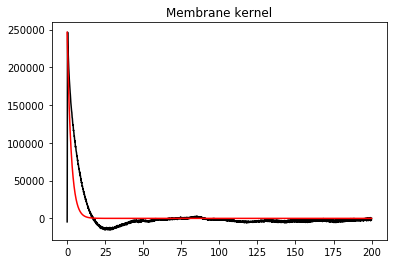

In [14]:
figure()
if two_electrodes:
    Km, V0 = full_kernel(V2_noise, I_noise, long_kernel_size, full_output=True)
else:
    Km, V0 = full_kernel(V_AEC, I_noise, long_kernel_size, full_output=True)
tk = arange(len(Km))*dt
fit = exp(-tk/(Rm*Cm))*dt/Cm
plot(tk/ms,Km,'k')
plot(tk/ms,fit,'r')
title("Membrane kernel")

In [15]:
# Subtract offset between the two headstages
if two_electrodes:
    delta_V = mean(V2[:,:int(pulse_start/dt)]) - mean(V[:,:int(pulse_start/dt)])
    V2 = [v2-delta_V for v2 in V2]
    print("Offset between the two traces = {} mV".format(delta_V/mV))

Offset between the two traces = -2.00801281925235 mV


In [16]:
# Calculate initial potential before the pulse
Vstart=mean(V[:,:int(pulse_start / dt)], axis=1)

Text(0.5, 1.0, 'Electrode kernel')

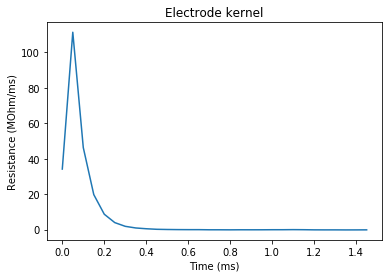

In [17]:
# *** Plotting ***
figure()
plot(arange(len(Ke))*dt/ms,Ke/dt*1e-9)
xlabel('Time (ms)')
ylabel('Resistance (MOhm/ms)')
title("Electrode kernel")

Text(0.5, 1.0, 'Initial potential')

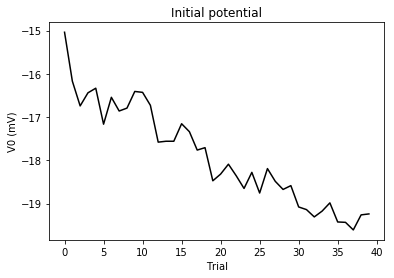

In [18]:
figure()
plot(Vstart/mV,'k')
xlabel('Trial')
ylabel('V0 (mV)')
title("Initial potential")

Text(0.5, 1.0, 'Responses to pulses')

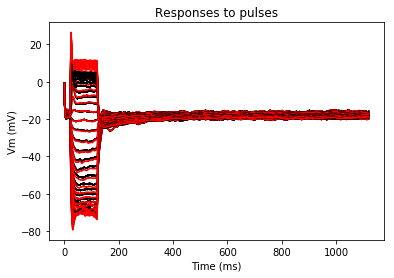

In [19]:
figure()
for Vi,V2i in zip(V,V2):
    plot(t/ms, lowpass(array(Vi) / mV, filtering, dt=dt), 'k')
    if two_electrodes:
        plot(t / ms, lowpass(array(V2i) / mV, filtering, dt=dt), 'r')
xlabel('Time (ms)')
ylabel('Vm (mV)')
title('Responses to pulses')

In [20]:
# if full:
#     # Do the two electrodes match?
#     if two_electrodes:
#         figure()
#         subplot(211)
#         for Vi,V2i,Ici in zip(V,V2,Ic):
#             plot(t/ms,lowpass((V2i-Vi) / mV, filtering, dt=dt), color=get_color(Ici))
#         ylabel('V2-V1 (mV)')
#         xlim(min(t / ms), max(t / ms))
#         title('Difference between electrode responses')
#         subplot(212)
#         for Vi,V2i,Ici in zip(V,V2,Ic):
#             ind = abs(Ici)>0.1*nA
#             color = get_color(Ici)
#             Vi, V2i, Ici = Vi[ind], V2i[ind], Ici[ind]
#             plot(t[ind]/ms,lowpass((V2i-Vi) / Ici /Mohm, filtering, dt=dt), color=color)
#         xlabel('Time (ms)')
#         ylabel('Resistance error (MOhm)')
#         xlim(min(t / ms), max(t / ms))

#     # Late current (at the end of the pulse)
#     if two_electrodes:
#         V_late=array([Vi[int((pulse_start+pulse_duration-1*ms)/dt)] for Vi in V2])
#     else:
#         V_late=array([Vi[int((pulse_start+pulse_duration-1*ms)/dt)] for Vi in V])
#     figure()
#     plot(V_late/mV,amplitudes/nA,'k')
#     ylabel('I (nA)')
#     xlabel('V (mV)')
#     title('Late current')

#     figure()
#     # Ionic current
#     # Current-based AEC
#     # We find the best linear predictor of dV_noise/dt from I_noise.
#     # This decomposes into membrane current and electrode current.
#     # We get the electrode contribution (roughly 1/C).
#     # Then we subtract the electrode contribution from subsequent recordings.
#     # (We accommodate for some delay)
#     if two_electrodes:
#         V_noise = V2_noise
#         Vpulses = V2
#         Vtrue = V2
#     else:
#         V_noise = V1_noise
#         Vpulses = Vraw
#         Vtrue = V # AEC compensated
#     K = full_kernel(diff(V_noise), I_noise[1:], kernel_size)
#     # Electrode kernel calculation
# #     Ke = electrode_kernel_soma(K, ekernel_size)

#     for Vi,Ici in zip(Vpulses,Ic):
#         dV = AEC_compensate(diff(Vi), Ici[1:], Ke)
#         Iionic = Cm * dV*volt/dt
#         plot(t[:-1]/ms, lowpass(-Iionic / nA, filtering, dt=dt),color=get_color(Ici)) # with the convention: inward <0
#     xlabel('Time (ms)')
#     ylabel('Current (nA)')
#     title('Ionic current')

#     # Ionic current with leak subtraction
#     figure()
#     n = len(Ic)*0
#     for Vi,V_AEC,Ici in zip(Vpulses[int(n/2):],Vtrue[int(n/2):],Ic[int(n/2):]):
#         #dV = AEC_compensate(diff(Vi), Ici[1:], Ke)
#         Iionic = - (V0-V_AEC[:-1])*volt/Rm + Cm * dV*volt/dt
#         plot(t[:-1] / ms, lowpass(-Iionic / nA, filtering, dt=dt), color=get_color(Ici))  # with the convention: inward <0
#     xlabel('Time (ms)')
#     ylabel('Current (nA)')
#     title('Ionic current minus leak, method 1')

#     if two_electrodes:
#         # Calculated by current-based AEC
#         # (problem: the kernel is too noisy)
#         figure()
#         p = 10
#         KI, I0 = full_kernel(I_noise[:-p] / amp, V_noise[p:], 30, full_output=True)
#         # Fixing the resistance
#         g = sum(KI)
#         print("Resistance from current kernel = {} Mohm".format(1 / g / Mohm))
#         if False:
#             KI+= (1/Rm2 - g)/len(KI) # Fixed from exponential fit
#         xlabel('Time (ms)')
#         plot(KI)
#         title('Current kernel')

#         figure()
#         n = len(Ic)*0
#         for Vi,V_AEC,Ici in zip(Vpulses[int(n/2):],Vtrue[int(n/2):],Ic[int(n/2):]):
#             #dV = AEC_compensate(diff(Vi), Ici[1:], Ke)
#             #Iionic = - (V0-V_AEC[:-1])*volt/Rm + Cm * dV*volt/dt
#             Iionic = -AEC_compensate(Ici[:-p], V_AEC[p:]-V0, KI)
#             #plot(t[:-1] / ms, lowpass(-Iionic / nA, filtering, dt=dt))  # with the convention: inward <0
#             plot(t[:-p]/ms, lowpass(-Iionic / nA, filtering, dt=dt), color=get_color(Ici)) # with the convention: inward <0
#         xlabel('Time (ms)')
#         ylabel('Current (nA)')
#         title('Ionic current minus leak, method 2')

# Pick Values 

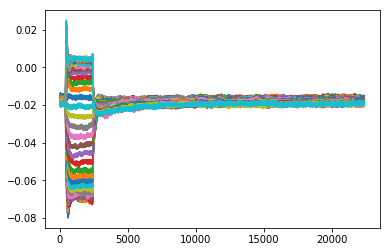

In [21]:
plot(V.transpose());

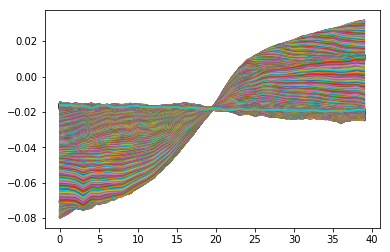

In [22]:
plot(V2);

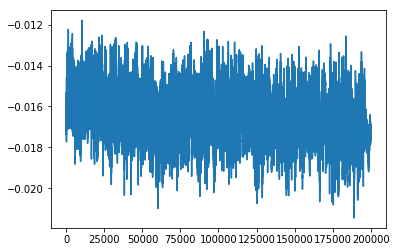

In [23]:
plot(V2_noise);

In [25]:
# plot(dV);

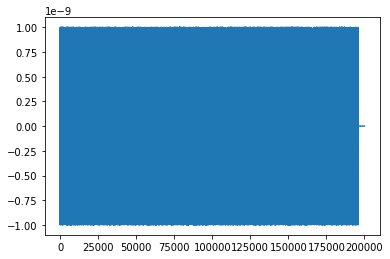

In [27]:
plot(I_noise);

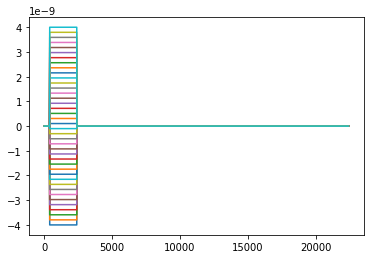

In [28]:
plot(Ic.transpose());

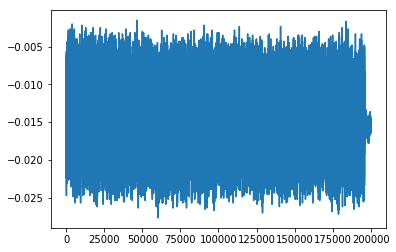

In [29]:
plot(V1_noise);

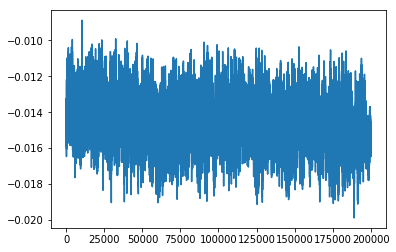

In [33]:
V_white_noise_AEC = AEC_compensate(V1_noise, I_noise, Ke)
plot(V_white_noise_AEC);

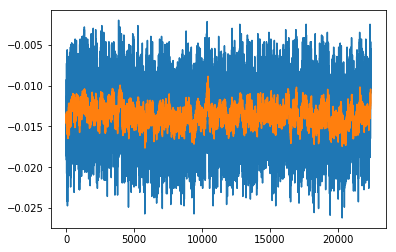

In [36]:
plot(V1_noise[:22400]);
plot(V_white_noise_AEC[:22400]);


In [37]:
V_wnAEC = V_white_noise_AEC[:22400]
I_noise_cut= I_noise[:22400]

## Save the data

In [38]:
df_v = pd.DataFrame(V)
df_v.head()

,0,1,2,3,4,5,6,7,8,9,...,22390,22391,22392,22393,22394,22395,22396,22397,22398,22399
0,-0.014680,-0.015009,-0.015009,-0.014845,-0.015667,-0.015503,-0.014516,-0.014187,-0.013858,-0.014680,...,-0.015503,-0.015503,-0.015503,-0.015996,-0.016489,-0.015667,-0.015996,-0.015009,-0.015503,-0.015009
1,-0.014845,-0.014516,-0.014845,-0.015174,-0.015503,-0.015996,-0.015832,-0.015009,-0.014845,-0.014516,...,-0.015503,-0.015832,-0.016489,-0.016325,-0.016160,-0.016489,-0.016489,-0.016160,-0.015503,-0.016160
2,-0.015832,-0.015503,-0.016160,-0.016325,-0.017476,-0.017805,-0.016983,-0.016489,-0.016489,-0.016818,...,-0.015996,-0.016325,-0.015996,-0.016818,-0.016654,-0.016654,-0.015832,-0.015996,-0.015996,-0.015338
3,-0.016983,-0.016818,-0.015996,-0.016983,-0.016654,-0.017312,-0.016983,-0.016489,-0.016654,-0.016654,...,-0.015503,-0.015996,-0.016325,-0.017312,-0.016818,-0.016818,-0.016160,-0.017147,-0.016489,-0.015832
4,-0.016160,-0.016654,-0.016325,-0.016489,-0.016160,-0.016489,-0.016818,-0.016325,-0.016818,-0.016160,...,-0.018957,-0.018792,-0.017805,-0.017970,-0.017970,-0.017641,-0.018134,-0.018299,-0.018299,-0.018463


In [39]:
df_ic = pd.DataFrame(Ic)
df_ic.head()

,0,1,2,3,4,5,6,7,8,9,...,22390,22391,22392,22393,22394,22395,22396,22397,22398,22399
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df_inoise = pd.DataFrame(I_noise_cut)
df_inoise.head()

,0
0,-5.459705e-10
1,2.641434e-10
2,1.032599e-10
3,-7.357271e-10
4,3.540778e-10


In [41]:
df_wn_v = pd.DataFrame(V_wnAEC)
df_wn_v.head()

,0
0,-0.014076
1,-0.014228
2,-0.014571
3,-0.014399
4,-0.014410


In [46]:
out_path= ''
df_v.to_csv(out_path+'cell1_v.csv')
df_ic.to_csv(out_path+'cell1_ic.csv')
df_inoise.to_csv(out_path+'cell1_i_noise.csv')
df_wn_v.to_csv(out_path+'cell1_v_noise.csv')

## Test Data Loading

In [47]:
dd = pd.read_csv('cell1_v.csv')
dd.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,22390,22391,22392,22393,22394,22395,22396,22397,22398,22399
0,0,-0.014680,-0.015009,-0.015009,-0.014845,-0.015667,-0.015503,-0.014516,-0.014187,-0.013858,...,-0.015503,-0.015503,-0.015503,-0.015996,-0.016489,-0.015667,-0.015996,-0.015009,-0.015503,-0.015009
1,1,-0.014845,-0.014516,-0.014845,-0.015174,-0.015503,-0.015996,-0.015832,-0.015009,-0.014845,...,-0.015503,-0.015832,-0.016489,-0.016325,-0.016160,-0.016489,-0.016489,-0.016160,-0.015503,-0.016160
2,2,-0.015832,-0.015503,-0.016160,-0.016325,-0.017476,-0.017805,-0.016983,-0.016489,-0.016489,...,-0.015996,-0.016325,-0.015996,-0.016818,-0.016654,-0.016654,-0.015832,-0.015996,-0.015996,-0.015338
3,3,-0.016983,-0.016818,-0.015996,-0.016983,-0.016654,-0.017312,-0.016983,-0.016489,-0.016654,...,-0.015503,-0.015996,-0.016325,-0.017312,-0.016818,-0.016818,-0.016160,-0.017147,-0.016489,-0.015832
4,4,-0.016160,-0.016654,-0.016325,-0.016489,-0.016160,-0.016489,-0.016818,-0.016325,-0.016818,...,-0.018957,-0.018792,-0.017805,-0.017970,-0.017970,-0.017641,-0.018134,-0.018299,-0.018299,-0.018463
